In [1]:
from shared_notebook_utils import *
from scipy.stats import gaussian_kde
from collections import Counter
# Add the datasets you want to analyze in 'dataset_dirnames'
# In this repository we include an example 'toy_dataset' that can be used to test the notebook.
dataset_dirnames = ['toy_dataset'] 
datasets = load_datasets(dirnames=dataset_dirnames, clean=True)
%matplotlib inline

# This notebook contains excerpts from the article: Font, F., & Serra, X. (2016). Tempo Estimation for Music Loops and a Simple Confidence Measure. In Proceedings of the Int. Conf. on Music Information Retrieval (ISMIR).
# License: CC-BY-4.0

/usr/local/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


## Cleanning datasets

Because of the nature of how the datasets were collected, we found that some of the loops do not have a BPM annotations that we can use as ground truth or have a BPM annotation which is outside what could be intuitively considered a reasonable tempo range. To avoid inconsistencies with the annotations, we clean the datasets by removing instances with no BPM annotation or with a BPM annotation outside a range of $[25, 300]$. 
Interestingly, we see that all the loops in our datasets are annotated with integer tempo values, meaning that it is not common for music loops to be produced with tempo values with less than 1 BPM resolution.

In [2]:
for count, dataset in enumerate(datasets):
    print 'Cleaning %s' % dataset.short_name,
    aceptable_instances = dataset.filter_data(condition=condition_instance_acceptable)
    n_instances_removed = len(dataset.data) - len(aceptable_instances.data)
    datasets[count] = aceptable_instances
    print 'done! (%i instances removed, %.2f%%)' % (n_instances_removed, 100.0 * n_instances_removed / len(dataset.data))
    
print title('Function used to filter each instance:')
print inspect.getsource(condition_instance_acceptable)

Cleaning TOYDS done! (0 instances removed, 0.00%)

Function used to filter each instance:
--------------------------------------

def condition_instance_acceptable(key, item, data):
    annotated_bpm = vfkp(item, 'annotations.bpm')
    if annotated_bpm == 0 or annotated_bpm is None:
        return False
    if annotated_bpm < 30 or annotated_bpm > 300:
        return False
    return True



## Basic dataset statistics

In [3]:
table_header = ['Dataset', 'N', 'T. Duration', 'Mean Duration', 'Durations range', 'Tempo range']
table_rows = list()
genres = dict()

for dataset in datasets:
    row = [dataset.short_name]
    row.append(len(dataset.data))
    durations = dataset.get_data('analysis.durations.duration')
    durations = np.array(durations)
    row.append('%ih %im' % (int(durations.sum()) / 3600, int(durations.sum() % 3600) / 60))
    row.append('%.2fs' % durations.mean())
    row.append('%.2fs - %.2fs' % (durations.min(), durations.max()))
    tempos = dataset.get_data('annotations.bpm')
    row.append('%i - %i' % (min(tempos), max(tempos)))    
    table_rows.append(row)

print title('Basic statistics per dataset')
print_table(table_header, table_rows, highlight_max=False)


Basic statistics per dataset
----------------------------

Dataset   N    T. Duration   Mean Duration   Durations range   Tempo range   
-----------------------------------------------------------------------------
TOYDS     10   0h 1m         6.43s           2.40s - 16.00s    91 - 180      


## Extra plots

The code below generates some extra plots (not found in the paper) which show relevant information about the datasets.

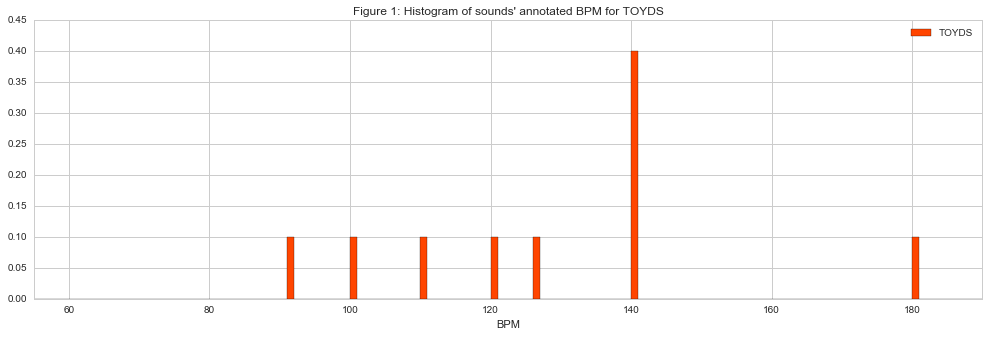

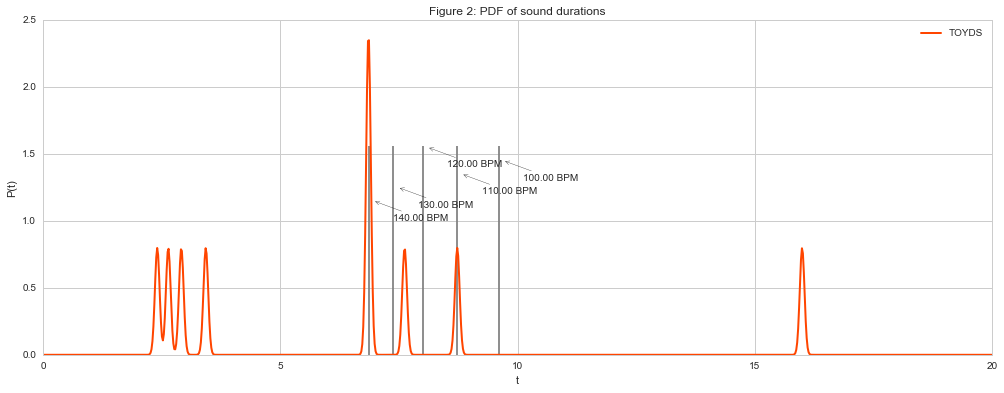

In [4]:
# BPM histograms for each dataset
n_datasets = len(datasets)
if not n_datasets:
    raise Exception("No datasets were specified or could be loaded!")
nrows = int(math.ceil(float(n_datasets)/2))
ncols = 1 if n_datasets < 2 else 2
fig1, axs = plt.subplots(nrows, ncols, figsize=(17, 5))

for count, dataset in enumerate(datasets):
    tempos = dataset.get_data('annotations.bpm')
    min_tempo = 30
    max_tempo = 300
    
    if n_datasets == 1:
        ax = axs
    elif n_datasets == 2:
        ax = axs[count]
    else:
        ax_col=count/2
        ax_row=count%2
        ax = axs[ax_col,ax_row]
    ax.hist(tempos, bins=max_tempo-min_tempo, range=(min_tempo,max_tempo), normed=True, label=dataset.short_name, color=COLORS[count])
    ax.set_xlabel('BPM')
    ax.set_xlim((55, 190))
    ax.legend()
    ax.set_title('Figure 1: Histogram of sounds\' annotated BPM for %s' % dataset.short_name)
plt.show()


# Probability density function of sounds' duration
fig2, ax2 = plt.subplots(1, 1, figsize=(17, 6))
for count, dataset in enumerate(datasets):
    sound_durations = dataset.get_data('analysis.durations.duration')
    sound_durations = np.array(sound_durations)
    kde = gaussian_kde(sound_durations, bw_method=0.05 / sound_durations.std(ddof=1))
    x_grid = np.linspace(0.0, 20.0, 1000)
    x = kde.evaluate(x_grid)
    ax2.plot(x_grid, x, color=COLORS[count], linewidth=2.0, label=dataset.short_name)
    x_peaks = detect_n_max_peaks(x, n=8)
    
ax2.set_title('Figure 2: PDF of sound durations')
ax2.set_xlabel('t')
ax2.set_ylabel('P(t)')
ax2.legend()
for count, peak_position in enumerate([8.0, 9.6, 8.72, 7.38, 6.86]):
    estimate_bpm = int(round(60.0/peak_position * 16))
    if 60 <= estimate_bpm <= 200:
        ax2.vlines(peak_position, 0, 1.56, label='tick', color='gray')
        label = '%.2f BPM' % estimate_bpm
        ax2.annotate(label, xy=(peak_position + 0.1, 1.55 - count * 0.1), xycoords='data',
                     xytext=(20, -20), textcoords='offset points',
                     arrowprops=dict(arrowstyle="->"))
plt.show()